In [2]:
import matplotlib.pyplot as plt
import numpy

In [11]:
model_params = {"T5":13, "GPT-3":175, "Jurassic-1":178, "GShard":600, "GLaM":1.2e3, "Switch-C":1.5e3}
model_type = {"T5":"dense", "GPT-3":"dense", "Jurassic-1":"dense", "GShard":"sparse", "GLaM":"sparse", "Switch-C":"sparse"}

In [12]:
categories = list(model_params.keys())
values = list(model_params.values())

colors = [ "r" if v == "dense" else "b" for v in model_type.values()]
print(cats, vals, colors)

['T5', 'GPT-3', 'Jurassic-1', 'GShard', 'GLaM', 'Switch-C'] [13000000000.0, 175000000000.0, 178000000000.0, 600000000000.0, 1200000000000.0, 1500000000000.0] ['r', 'r', 'r', 'b', 'b', 'b']


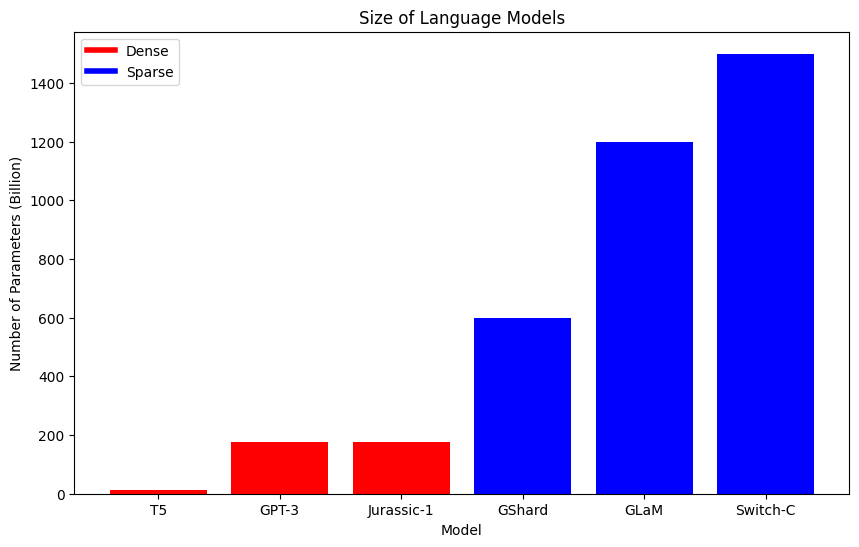

In [15]:
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color=colors)

# Add titles and labels
plt.title('Size of Language Models')
plt.xlabel('Model')
plt.ylabel('Number of Parameters (Billion)')

# Create custom legends
red_patch = plt.Line2D([0], [0], color='red', lw=4, label='Dense')
blue_patch = plt.Line2D([0], [0], color='blue', lw=4, label='Sparse')

plt.legend(handles=[red_patch, blue_patch])

# Display the plot
plt.show()

# Baseline

In [19]:
import transformers
from transformers import (
    RobertaForMaskedLM, RobertaConfig, RobertaTokenizerFast,
    GPTNeoForCausalLM, GPTNeoConfig, GPT2TokenizerFast
)

In [20]:
transformers.set_seed(123)

In [21]:
config_gpt = dict(

    # EMBEDDING PARAMETERS
    vocab_size              = 10_000,   # number of tokens in the vocabulary 
    hidden_size             = 256,      # embedding size (vector length) of each token 
    max_position_embeddings = 512,      # maximum sequence length (context window)

    # BLOCKS (ATTN & FFN)
    num_layers          = 2,                    # number of transformer blocks
    attention_types     = [[["global", "local"], 1]], # (GPT-Neo-specific) global and local attention 
    num_heads           = 4,                    # attention heads
    window_size         = 256,                  # (GPT-Neo-specific) for local attention 
    intermediate_size   = 256 * 16,                 # size of 'up-projection' layer in FFN

    pad_token_id = 0,           # need to specify this for tokenizer interop between models
)

config_rob = dict(
    
    # EMBEDDING PARAMETERS
    vocab_size              = 10_000,   
    hidden_size             = 256,      
    # we add 1 as RoBERTa uses a special position embedding for the padding token (zero vector)
    max_position_embeddings = config_gpt['max_position_embeddings'] + 1,

    # BLOCKS (of course naming is different in roberta :) )
    num_hidden_layers = config_gpt['num_layers'],
    num_attention_heads = config_gpt['num_heads'],
    intermediate_size=256 * 16,                     

    pad_token_id = 0,
)

config_gpt = GPTNeoConfig(**config_gpt)
config_rob = RobertaConfig(**config_rob)

In [22]:
gpt = GPTNeoForCausalLM(config=config_gpt)
rob = RobertaForMaskedLM(config=config_rob)

print(f'''
    This GPT has {gpt.num_parameters():,} parameters,
     and ROB has {rob.num_parameters():,} parameters.
    ''')



    This GPT has 7,421,440 parameters,
     and ROB has 7,500,048 parameters.
    


# MOE

In [44]:
from sparse_gpt_neo import SparseGPTNeoConfig, SparsityType, SparseGPTNeoForCausalLM
from sparse_roberta import SparseRobertaConfig, SparseRobertaForMaskedLM

## GPT

In [71]:
dim_in = 256
intermediate_factor = 16 # for baseline ffn, intermediate size intermediate factor * input dim
sparsity_type=SparsityType.MOE
num_experts = 4
topk=1
intermediate_size = round( (intermediate_factor * dim_in - num_experts) / num_experts )
print("intermediate layer size is", intermediate_size)

intermediate layer size is 1023


In [72]:
config = SparseGPTNeoConfig(

    # number of tokens in the vocabulary 
    vocab_size = 10_000, 
    # embedding size (vector length) of each token 
    hidden_size=dim_in, 
    # we thus have an embedding block of 512 x 10'000 parameters

    # maximum sequence length, though inputs longer than `hidden_size` will be iteratively processed
    max_position_embeddings = 512, 

    # number of transformer blocks. div by 2 for attention_types
    num_layers=2, 
    # for global and local attention (GPT-Neo-specific)
    attention_types=[[["global", "local"], 1]], 

    num_heads=4,     # attention heads
    window_size=384, # for local attention (GPT-Neo-specific)

    sparsity_type=sparsity_type,
    num_experts=num_experts,
    topk=topk,
    intermediate_size=intermediate_size, # size of 'up-projection' layer in FFN
)

In [73]:
gpt = SparseGPTNeoForCausalLM(config)
print("gpt",gpt.num_parameters())

gpt 7422968


## RoBERTa

In [74]:
config = SparseRobertaConfig(
    
    # EMBEDDING PARAMETERS
    vocab_size              = 10_000,   
    hidden_size             = 256,      
    # we add 1 as RoBERTa uses a special position embedding for the padding token (zero vector)
    max_position_embeddings = 512 + 1,

    # BLOCKS (of course naming is different in roberta :) )
    num_hidden_layers = 2,
    num_attention_heads = 4,                   
    pad_token_id = 0,

    sparsity_type=sparsity_type,
    num_experts=num_experts,
    topk=topk,
    intermediate_size=intermediate_size, # size of 'up-projection' layer in FFN
)

In [75]:
rob = SparseRobertaForMaskedLM(config=config)
print("rob",rob.num_parameters())

rob 7501576


# CNT

In [52]:
dim_in = 256
intermediate_factor = 16 # for baseline ffn, intermediate size intermediate factor * input dim
sparsity_type=SparsityType.CNT
num_blocks = 16 #32, 64
dim_lowrank = round(dim_in/num_blocks)
intermediate_size = dim_in * (2 * intermediate_factor * num_blocks  - 1) / (2*num_blocks+1) 
intermediate_size = num_blocks * round(intermediate_size/ num_blocks) # round to nearest multiple of num blocks
print("intermediate layer size is", intermediate_size)


intermediate layer size is 3968


In [64]:
config = SparseGPTNeoConfig(

    # number of tokens in the vocabulary 
    vocab_size = 10_000, 
    # embedding size (vector length) of each token 
    hidden_size=dim_in, 
    # we thus have an embedding block of 512 x 10'000 parameters

    # maximum sequence length, though inputs longer than `hidden_size` will be iteratively processed
    max_position_embeddings = 512, 

    # number of transformer blocks. div by 2 for attention_types
    num_layers=2, 
    # for global and local attention (GPT-Neo-specific)
    attention_types=[[["global", "local"], 1]], 

    num_heads=4,     # attention heads
    window_size=384, # for local attention (GPT-Neo-specific)

    sparsity_type=sparsity_type,
    num_blocks = num_blocks,
    dim_lowrank = dim_lowrank,
    intermediate_size=intermediate_size, # size of 'up-projection' layer in FFN
)

gpt = SparseGPTNeoForCausalLM(config)
print("gpt", gpt.num_parameters())

config = SparseRobertaConfig(
    
    # EMBEDDING PARAMETERS
    vocab_size              = 10_000,   
    hidden_size             = 256,      
    # we add 1 as RoBERTa uses a special position embedding for the padding token (zero vector)
    max_position_embeddings = 512 + 1,

    # BLOCKS (of course naming is different in roberta :) )
    num_hidden_layers = 2,
    num_attention_heads = 4,                   
    pad_token_id = 0,

    sparsity_type=sparsity_type,
    num_blocks = num_blocks,
    dim_lowrank = dim_lowrank,
    intermediate_size=intermediate_size, # size of 'up-projection' layer in FFN
)
rob = SparseRobertaForMaskedLM(config=config)
print("rob",rob.num_parameters())

gpt 7390080
rob 7468688


In [77]:
dim_in = 256
intermediate_factor = 16 # for baseline ffn, intermediate size intermediate factor * input dim
sparsity_type=SparsityType.CNT
num_blocks = 32 #, 64
dim_lowrank = round(dim_in/num_blocks)
intermediate_size = dim_in * (2 * intermediate_factor * num_blocks  - 1) / (2*num_blocks+1) 
intermediate_size = num_blocks * round(intermediate_size/ num_blocks) # round to nearest multiple of num blocks
print("intermediate layer size is", intermediate_size)


intermediate layer size is 4032


In [66]:
config = SparseGPTNeoConfig(

    # number of tokens in the vocabulary 
    vocab_size = 10_000, 
    # embedding size (vector length) of each token 
    hidden_size=dim_in, 
    # we thus have an embedding block of 512 x 10'000 parameters

    # maximum sequence length, though inputs longer than `hidden_size` will be iteratively processed
    max_position_embeddings = 512, 

    # number of transformer blocks. div by 2 for attention_types
    num_layers=2, 
    # for global and local attention (GPT-Neo-specific)
    attention_types=[[["global", "local"], 1]], 

    num_heads=4,     # attention heads
    window_size=384, # for local attention (GPT-Neo-specific)

    sparsity_type=sparsity_type,
    num_blocks = num_blocks,
    dim_lowrank = dim_lowrank,
    intermediate_size=intermediate_size, # size of 'up-projection' layer in FFN
)

gpt = SparseGPTNeoForCausalLM(config)
print("gpt", gpt.num_parameters())

config = SparseRobertaConfig(
    
    # EMBEDDING PARAMETERS
    vocab_size              = 10_000,   
    hidden_size             = 256,      
    # we add 1 as RoBERTa uses a special position embedding for the padding token (zero vector)
    max_position_embeddings = 512 + 1,

    # BLOCKS (of course naming is different in roberta :) )
    num_hidden_layers = 2,
    num_attention_heads = 4,                   
    pad_token_id = 0,

    sparsity_type=sparsity_type,
    num_blocks = num_blocks,
    dim_lowrank = dim_lowrank,
    intermediate_size=intermediate_size, # size of 'up-projection' layer in FFN
)
rob = SparseRobertaForMaskedLM(config=config)
print("rob",rob.num_parameters())

gpt 7424384
rob 7502992


In [80]:
dim_in = 256
intermediate_factor = 16 # for baseline ffn, intermediate size intermediate factor * input dim
sparsity_type=SparsityType.CNT
num_blocks = 64
dim_lowrank = round(dim_in/num_blocks)
intermediate_size = dim_in * (2 * intermediate_factor * num_blocks  - 1) / (2*num_blocks+1) 
intermediate_size = num_blocks * round(intermediate_size/ num_blocks) # round to nearest multiple of num blocks
print("intermediate layer size is", intermediate_size)


intermediate layer size is 4032


In [68]:
config = SparseGPTNeoConfig(

    # number of tokens in the vocabulary 
    vocab_size = 10_000, 
    # embedding size (vector length) of each token 
    hidden_size=dim_in, 
    # we thus have an embedding block of 512 x 10'000 parameters

    # maximum sequence length, though inputs longer than `hidden_size` will be iteratively processed
    max_position_embeddings = 512, 

    # number of transformer blocks. div by 2 for attention_types
    num_layers=2, 
    # for global and local attention (GPT-Neo-specific)
    attention_types=[[["global", "local"], 1]], 

    num_heads=4,     # attention heads
    window_size=384, # for local attention (GPT-Neo-specific)

    sparsity_type=sparsity_type,
    num_blocks = num_blocks,
    dim_lowrank = dim_lowrank,
    intermediate_size=intermediate_size, # size of 'up-projection' layer in FFN
)

gpt = SparseGPTNeoForCausalLM(config)
print("gpt", gpt.num_parameters())

config = SparseRobertaConfig(
    
    # EMBEDDING PARAMETERS
    vocab_size              = 10_000,   
    hidden_size             = 256,      
    # we add 1 as RoBERTa uses a special position embedding for the padding token (zero vector)
    max_position_embeddings = 512 + 1,

    # BLOCKS (of course naming is different in roberta :) )
    num_hidden_layers = 2,
    num_attention_heads = 4,                   
    pad_token_id = 0,

    sparsity_type=sparsity_type,
    num_blocks = num_blocks,
    dim_lowrank = dim_lowrank,
    intermediate_size=intermediate_size, # size of 'up-projection' layer in FFN
)
rob = SparseRobertaForMaskedLM(config=config)
print("rob",rob.num_parameters())

gpt 7390080
rob 7468688


# PKM

In [101]:
dim_in = 256
intermediate_factor = 4
intermediate_size = dim_in * intermediate_factor
sparsity_type=SparsityType.PKM
dim_key = intermediate_size/2
num_query_heads = 4
num_subkeys = -(num_query_heads * dim_key / dim_in) + ((num_query_heads * dim_key / dim_in)**2 - 2 * (num_query_heads * dim_key - 16 * dim_in) )**0.5
num_subkeys = round(num_subkeys)
topk = 3

print("number of sumkeys", num_subkeys)


number of sumkeys 56


In [102]:
(dim_in * 2 * dim_key * num_query_heads + dim_in * num_subkeys**2 + 2 * dim_key * num_subkeys * num_query_heads) - (dim_in * 16 * dim_in * 2)

-16384.0

In [103]:
config = SparseGPTNeoConfig(

    # number of tokens in the vocabulary 
    vocab_size = 10_000, 
    # embedding size (vector length) of each token 
    hidden_size=dim_in, 
    # we thus have an embedding block of 512 x 10'000 parameters

    # maximum sequence length, though inputs longer than `hidden_size` will be iteratively processed
    max_position_embeddings = 512, 

    # number of transformer blocks. div by 2 for attention_types
    num_layers=2, 
    # for global and local attention (GPT-Neo-specific)
    attention_types=[[["global", "local"], 1]], 

    num_heads=4,     # attention heads
    window_size=384, # for local attention (GPT-Neo-specific)

    sparsity_type=sparsity_type,
    num_query_heads = num_query_heads,
    num_subkeys = num_subkeys,
    topk = topk,
    intermediate_size=intermediate_size, # size of 'up-projection' layer in FFN
)

gpt = SparseGPTNeoForCausalLM(config)
print("gpt", gpt.num_parameters())

config = SparseRobertaConfig(
    
    # EMBEDDING PARAMETERS
    vocab_size              = 10_000,   
    hidden_size             = 256,      
    # we add 1 as RoBERTa uses a special position embedding for the padding token (zero vector)
    max_position_embeddings = 512 + 1,

    # BLOCKS (of course naming is different in roberta :) )
    num_hidden_layers = 2,
    num_attention_heads = 4,                   
    pad_token_id = 0,

    sparsity_type=sparsity_type,
    num_query_heads = num_query_heads,
    num_subkeys = num_subkeys,
    topk = topk,
    intermediate_size=intermediate_size, # size of 'up-projection' layer in FFN
)
rob = SparseRobertaForMaskedLM(config=config)
print("rob",rob.num_parameters())

gpt 7396352
rob 7474960


# Num parameters

In [115]:
model_params = {
    "GPT - baseline": 7421440,
    "RoBERTa - baseline":7500048,
    "GPT - MoE":7422968,
    "RoBERTA - MoE": 7501576,

    "GPT - CNT (N=16)":7390080,
    "RoBERTA - CNT (N=16)":7468688,
    "GPT - CNT (N=32)":7424384,
    "RoBERTA - CNT (N=32)":7502992,
    "GPT - CNT (N=64)":7390080,
    "RoBERTA - CNT (N=64)":7468688,
    "GPT - PKM":7396352,
    "RoBERTA - PKM":7474960,
     
}

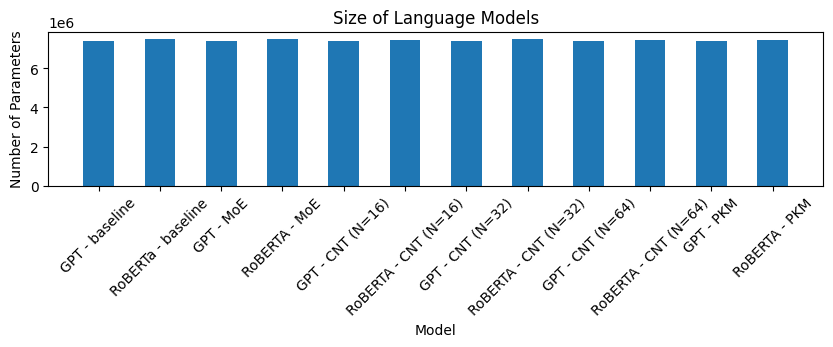

In [120]:
categories = list(model_params.keys())
values = list(model_params.values())

plt.figure(figsize=(10, 2))
bars = plt.bar(categories, values,width=0.5)

# Add titles and labels
plt.title('Size of Language Models')
plt.xlabel('Model')
plt.ylabel('Number of Parameters')
plt.xticks(rotation=45)

# Display the plot
plt.show()